In [1]:
%pip --quiet install qiskit pylatexenc
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.circuit.library import QFT
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from random import randint, seed
from numpy import gcd
# Loading your IBM Q account(s)
# IBMQ.load_account()
backend = Aer.get_backend('qasm_simulator')

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
def initialize_qubits(qc, n, m):
    qc.h(range(n)) # apply hadamard gates
    qc.x(n+m-1) # set qubit to 1

def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U


def modular_exponentiation(qc, n, m, a):
    for x in range(n):
        exponent = 2**x
        qc.append(a_x_mod15(a, exponent), [x] + list(range(n, n+m)))

def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits), do_swaps=False).inverse(), measurement_qubits)


def measure(qc, n):
    qc.measure(n, n)

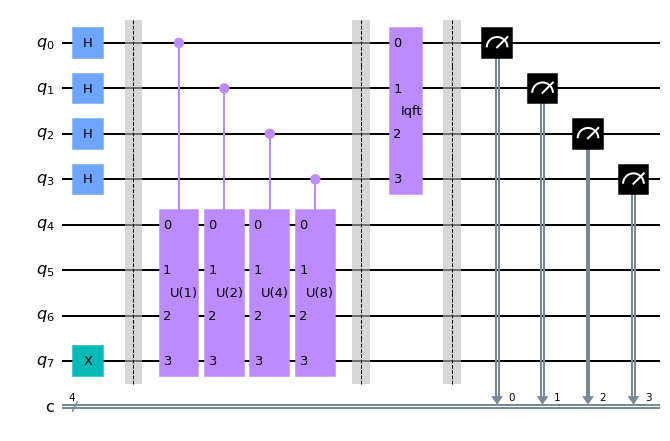

In [3]:
# prime number
N = 15
# a guess factor
seed(7)
a = randint(2, N) # 1 < a < N

n = 4; m = 4

# set up quantum circuit
qc = QuantumCircuit(n+m, n)

# initialize the qubits
initialize_qubits(qc, n, m)
qc.barrier()

# apply modular exponentiation
modular_exponentiation(qc, n, m, a)
qc.barrier()

# apply inverse QFT
apply_iqft(qc, range(n))
qc.barrier()

# measure the n measurement qubits
measure(qc, range(n))

qc.draw()

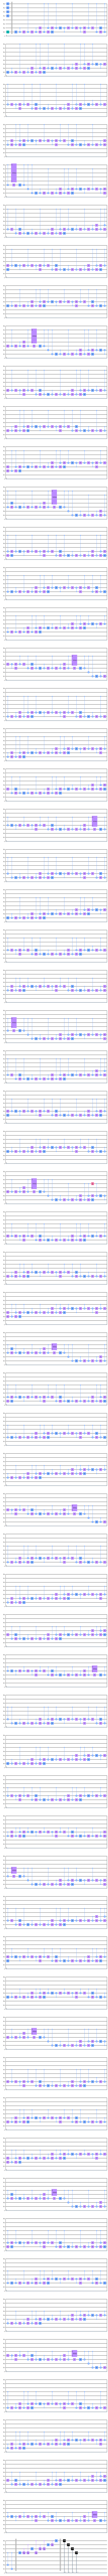

In [4]:
transpile(qc, optimization_level=3).draw()

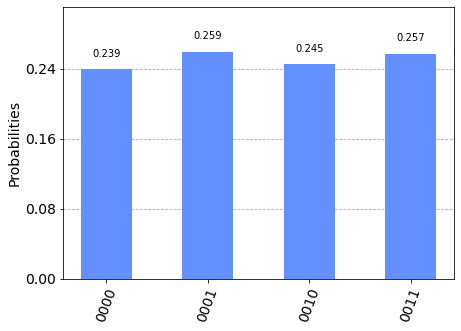

In [5]:
counts = execute(qc, backend=simulator).result().get_counts(qc)

plot_histogram(counts)

In [6]:
# convert and add binary periods to list
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

print("Measured periods:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured periods:	0	4	8	12

In [7]:
periods = []

for measured_value in counts_dec:
    if measured_value % 2 == 0: # x is even
        if (int((a ** (measured_value/2))) + 1) % N != 0:
            periods.append(measured_value)

In [8]:
factors = set()

for x in periods:
    guesses = [gcd(int((a ** (measured_value/2))) + 1, N),
               gcd(int((a ** (measured_value/2))) - 1, N)]
    for guess in guesses:
        # ignore trivial factors
        if guess != 1 and guess != N and N % guess == 0:
            factors.add(guess)

if len(factors):
    P = factors.pop()
    Q = factors.pop() if len(factors) else N // P
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

P = 3
Q = 5

 3 x 5 = 15, True
